In [82]:
from astropy.io import fits
from astropy.table import vstack
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
import seaborn as sns
import scipy.stats
import seaborn as sns
from numpy.random import normal
import seaborn as sns
import numpy
import numexpr
from scipy import stats

In [83]:
#import s5 data
hdul = fits.open('s5cat_dr3_2.fits')
data = hdul[1].data
df = pd.DataFrame(np.array(data).byteswap().newbyteorder()).reset_index(drop=True)
print(df['object_name'])


0              b'Styx'
1              b'Styx'
2              b'Styx'
3              b'Styx'
4              b'Styx'
             ...      
84102        b'Orphan'
84103    b'Phlegethon'
84104    b'Phlegethon'
84105    b'Phlegethon'
84106    b'Phlegethon'
Name: object_name, Length: 84107, dtype: object


In [32]:
#import gaia cluster data 
clusters = np.genfromtxt('GaiaTools-master/result.txt', delimiter='\t', skip_header=1, dtype=float)
print(clusters[0])


[        nan  6.0240e+00 -7.2081e+01  4.5200e+00  3.0000e-02 -1.7450e+01
  1.6000e-01  1.2200e+01  4.0000e+01  5.2590e+00 -2.5430e+00  2.3200e-01
  2.5000e-02  2.5000e-02 -0.0000e+00  9.0000e-03]


In [33]:
#cluster list
cluster_candidate= [
 'Antlia2',
 'Crater2',
 'NGC1261',
 'NGC1851',
 'NGC1904',
 'NGC3201',
 'NGC4590',
 'NGC6316',
 'NGC7078',
 'NGC7089',
 'Pal13',
 'Pal15',
 'Pal5',
]

test for using astropy.match_coordinates

In [239]:
name = 'Crater2'
cluster_name =[name]
df = pd.DataFrame(np.array(data).byteswap().newbyteorder()).reset_index(drop=True)
df['object_name']=df['object_name'].str.decode('utf-8').fillna(df['object_name'])

print(df.shape)
for count,stream in enumerate(cluster_name):

    stars = df[df['object_name'].str.contains(stream)]
    print(stars.shape)
    stars = stars[stars['vel_calib']>-500]
    stars = stars[stars['vel_calib']<500]
    stars = stars[stars['feh50']<-1]
    #bug found. no selections should be done to this
    #streams = field[field['priority']>8].reset_index(drop=True)

    if len(stars['ra'])>0:

        original_ra = np.array(stars['ra'])
        original_dec = np.array(stars['dec'])

c = SkyCoord(ra=original_ra*u.degree, dec=original_dec*u.degree)
catalog = SkyCoord(ra=clusters[:,1]*u.degree, dec=clusters[:,2]*u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog)

print(stats.mode(idx)[0][0])



(84107, 258)
(981, 258)
21


original ra,dec

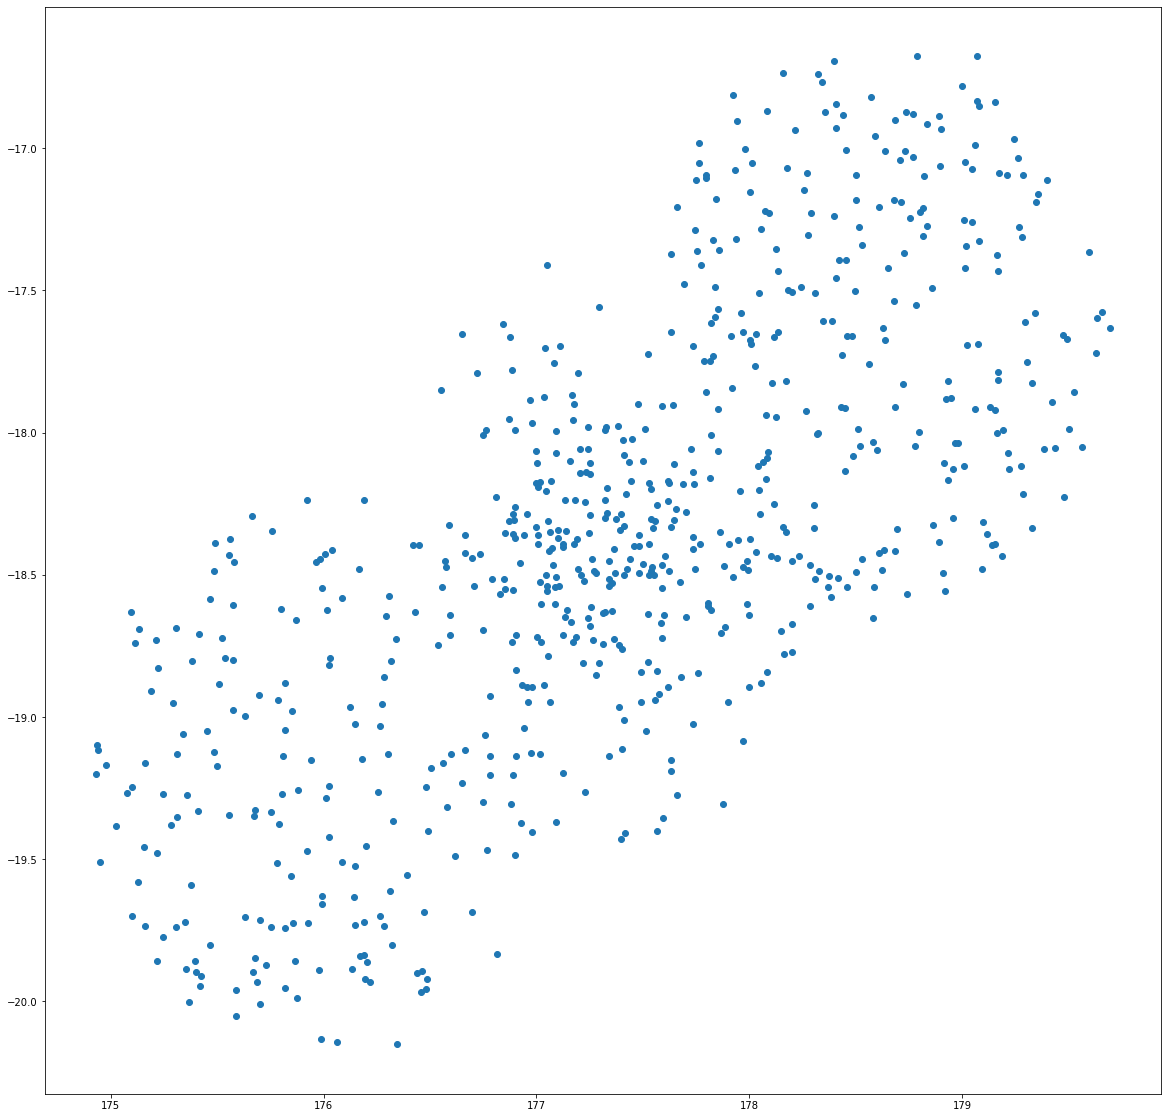

In [240]:
import seaborn as sns
plt.figure(figsize=(20,20))
plt.scatter(original_ra, original_dec)
plt.show()

rotation

In [241]:
#rotation algorithm
from numpy import sin,cos,deg2rad,rad2deg,arctan2,sqrt

def cv_coord(a,b,c,fr=None,to=None,degr=False):
	if degr:
		degrad = deg2rad
		raddeg = rad2deg
	else:
		degrad = lambda x: x
		raddeg = lambda x: x
	if fr=='sph':
		x=c*cos(degrad(a))*cos(degrad(b))
		y=c*sin(degrad(a))*cos(degrad(b))
		z=c*sin(degrad(b))
	elif fr=='rect':
		x=a
		y=b
		z=c
	elif fr is None:
		raise Exception('You must specify the input coordinate system')
	else:
		raise Exception('Unknown input coordinate system')
	if to=='rect':
		return (x,y,z)
	elif to=='sph':
		ra = raddeg(arctan2(y,x))
		dec = raddeg(arctan2(z,sqrt(x**2+y**2)))
		rad = sqrt(x**2+y**2+z**2)
		return (ra,dec,rad)
	elif to is None:
		raise Exception('You must specify the output coordinate system')
	else:
		raise Exception('Unknown output coordinate system')


def torect(ra,dec):
	x=numexpr.evaluate('cos(ra/57.295779513082323)*cos(dec/57.295779513082323)')
	y=numexpr.evaluate('sin(ra/57.295779513082323)*cos(dec/57.295779513082323)')
	z=numexpr.evaluate('sin(dec/57.295779513082323)')
	return x,y,z

def fromrect(x,y,z):
	ra=numexpr.evaluate('arctan2(y,x)*57.295779513082323')
	dec=numexpr.evaluate('57.295779513082323*arctan2(z,sqrt(x**2+y**2))')
	return ra,dec

def sphere_rotate(ra, dec, rapol, decpol, ra0, revert=False):
	""" rotate ra,dec to a new spherical coordinate system where the pole is 
		at rapol,decpol and the zeropoint is at ra=ra0 
		revert flag allows to reverse the transformation
	"""

	x,y,z=torect(ra,dec)

	tmppol=cv_coord(rapol,decpol,1,degr=True,fr='sph',to='rect') #pole axis
	tmpvec1=cv_coord(ra0,0,1,degr=True,fr='sph',to='rect') #x axis
	tmpvec1=numpy.array(tmpvec1)

	tmpvec1[2]=(-tmppol[0]*tmpvec1[0]-tmppol[1]*tmpvec1[1])/tmppol[2]
	tmpvec1/=numpy.sqrt((tmpvec1**2).sum())
	tmpvec2=numpy.cross(tmppol,tmpvec1) # y axis 

	if not revert:
		Axx,Axy,Axz=tmpvec1
		Ayx,Ayy,Ayz=tmpvec2
		Azx,Azy,Azz=tmppol
	else:
		Axx,Ayx,Azx=tmpvec1
		Axy,Ayy,Azy=tmpvec2
		Axz,Ayz,Azz=tmppol
	xnew = numexpr.evaluate('x*Axx+y*Axy+z*Axz')
	ynew = numexpr.evaluate('x*Ayx+y*Ayy+z*Ayz')
	znew = numexpr.evaluate('x*Azx+y*Azy+z*Azz')
	
	del x,y,z
	new_ra, new_dec = fromrect(xnew,ynew,znew)
	return new_ra,new_dec

In [242]:
#transformation doing it!!!
pm_ra = np.array(stars['pmra'])
pm_dec = np.array(stars['pmdec'])
radial_velocity = np.array(stars['vel_calib'])
metalicity = np.array(stars['feh50'])
g_band = np.array(stars['decam_g'])
r_band = np.array(stars['decam_r'])  

        
original_ra = np.array(stars['ra'])
original_dec = np.array(stars['dec'])

global_cluster_original_ra = clusters[stats.mode(idx)[0][0],1]
global_cluster_original_dec = clusters[stats.mode(idx)[0][0],2]
global_cluster_pmra_before = clusters[stats.mode(idx)[0][0],9]
global_cluster_pmdec_before = clusters[stats.mode(idx)[0][0],10]

global_cluster_after_ra = global_cluster_pmra_before/3600000 + global_cluster_original_ra
global_cluster_after_dec = global_cluster_pmdec_before/3600000 + global_cluster_original_dec


after_ra = pm_ra/3600000 + original_ra
after_dec = pm_dec/3600000 +  original_dec

combined = np.stack((original_ra,original_dec), axis=1)
#get the max and min angle loc

sorted_combined = combined[np.argsort(combined[:,1])]
print(sorted_combined[0],sorted_combined[-1])
min_spherical = sorted_combined[0]
max_spherical = sorted_combined[-1]

#get tangential angles

x_1, y_1, z_1 = torect((min_spherical[0]),(min_spherical[1]))
x_2, y_2, z_2 = torect(max_spherical[0], max_spherical[1])
print(x_1,y_1,z_1)
print(x_2,y_2,z_2)
#find the pole

vector_1 = [x_1,y_1,z_1]
vector_2 = [x_2,y_2,z_2]

product = np.cross(vector_1, vector_2)

pol_ra, pol_dec = fromrect(product[0], product[1], product[2])
        
#rotate the axis

#get new angles
original_phi_1, original_phi_2 = sphere_rotate(original_ra, original_dec, pol_ra, pol_dec, ra0=0)
after_phi_1, after_phi_2 = sphere_rotate(after_ra, after_dec, pol_ra, pol_dec, ra0=0)

pmra_rotated = after_phi_1 - original_phi_1
pmdec_rotated = after_phi_2 - original_phi_2

transformed_cluster_phi_1_before, transformed_cluster_phi_2_before = sphere_rotate(global_cluster_original_ra, global_cluster_original_dec, pol_ra, pol_dec,ra0=0)
transformed_cluster_phi_1_after, transformed_cluster_phi_2_after = sphere_rotate(global_cluster_after_ra, global_cluster_after_dec, pol_ra, pol_dec, ra0=0)

pmphi1 = transformed_cluster_phi_1_after - transformed_cluster_phi_1_before
pmphi2 = transformed_cluster_phi_2_after - transformed_cluster_phi_2_before



all_columns = {'original_phi_1':original_phi_1,'pmdec_rotated':pmdec_rotated,'radial_velocity':radial_velocity,'original_phi_2':original_phi_2,'pmra_rotated_star':pmra_rotated, 'g_band':g_band, 'r_band':r_band}

new_frame = pd.DataFrame(all_columns)

[176.34565417 -20.15163333] [178.78595417 -16.67538333]
-0.9368753650502463 0.05983541196519522 -0.34450584006214363
-0.9577308283686079 0.020296489130201042 -0.2869489726787113


In [243]:
#mask
mean_radial_velocity = 2.34
masked = new_frame
masked = masked[masked['pmdec_rotated']>float(pmphi2-0.25*1e-6)]
masked = masked[masked['pmdec_rotated']<float(pmphi2+0.25*1e-6)]

masked = masked[masked['pmra_rotated_star']>float(pmphi1-0.25*1e-6)]
masked = masked[masked['pmra_rotated_star']<float(pmphi1+0.25*1e-6)]

masked = masked[masked['radial_velocity']>float(mean_radial_velocity-10)]
masked = masked[masked['radial_velocity']<float(mean_radial_velocity+10)]
#masked = masked[(masked['g_band']-masked['r_band'])>0.2]
#masked = masked[(masked['g_band']-masked['r_band'])<1.5]


<Figure size 1440x1440 with 0 Axes>

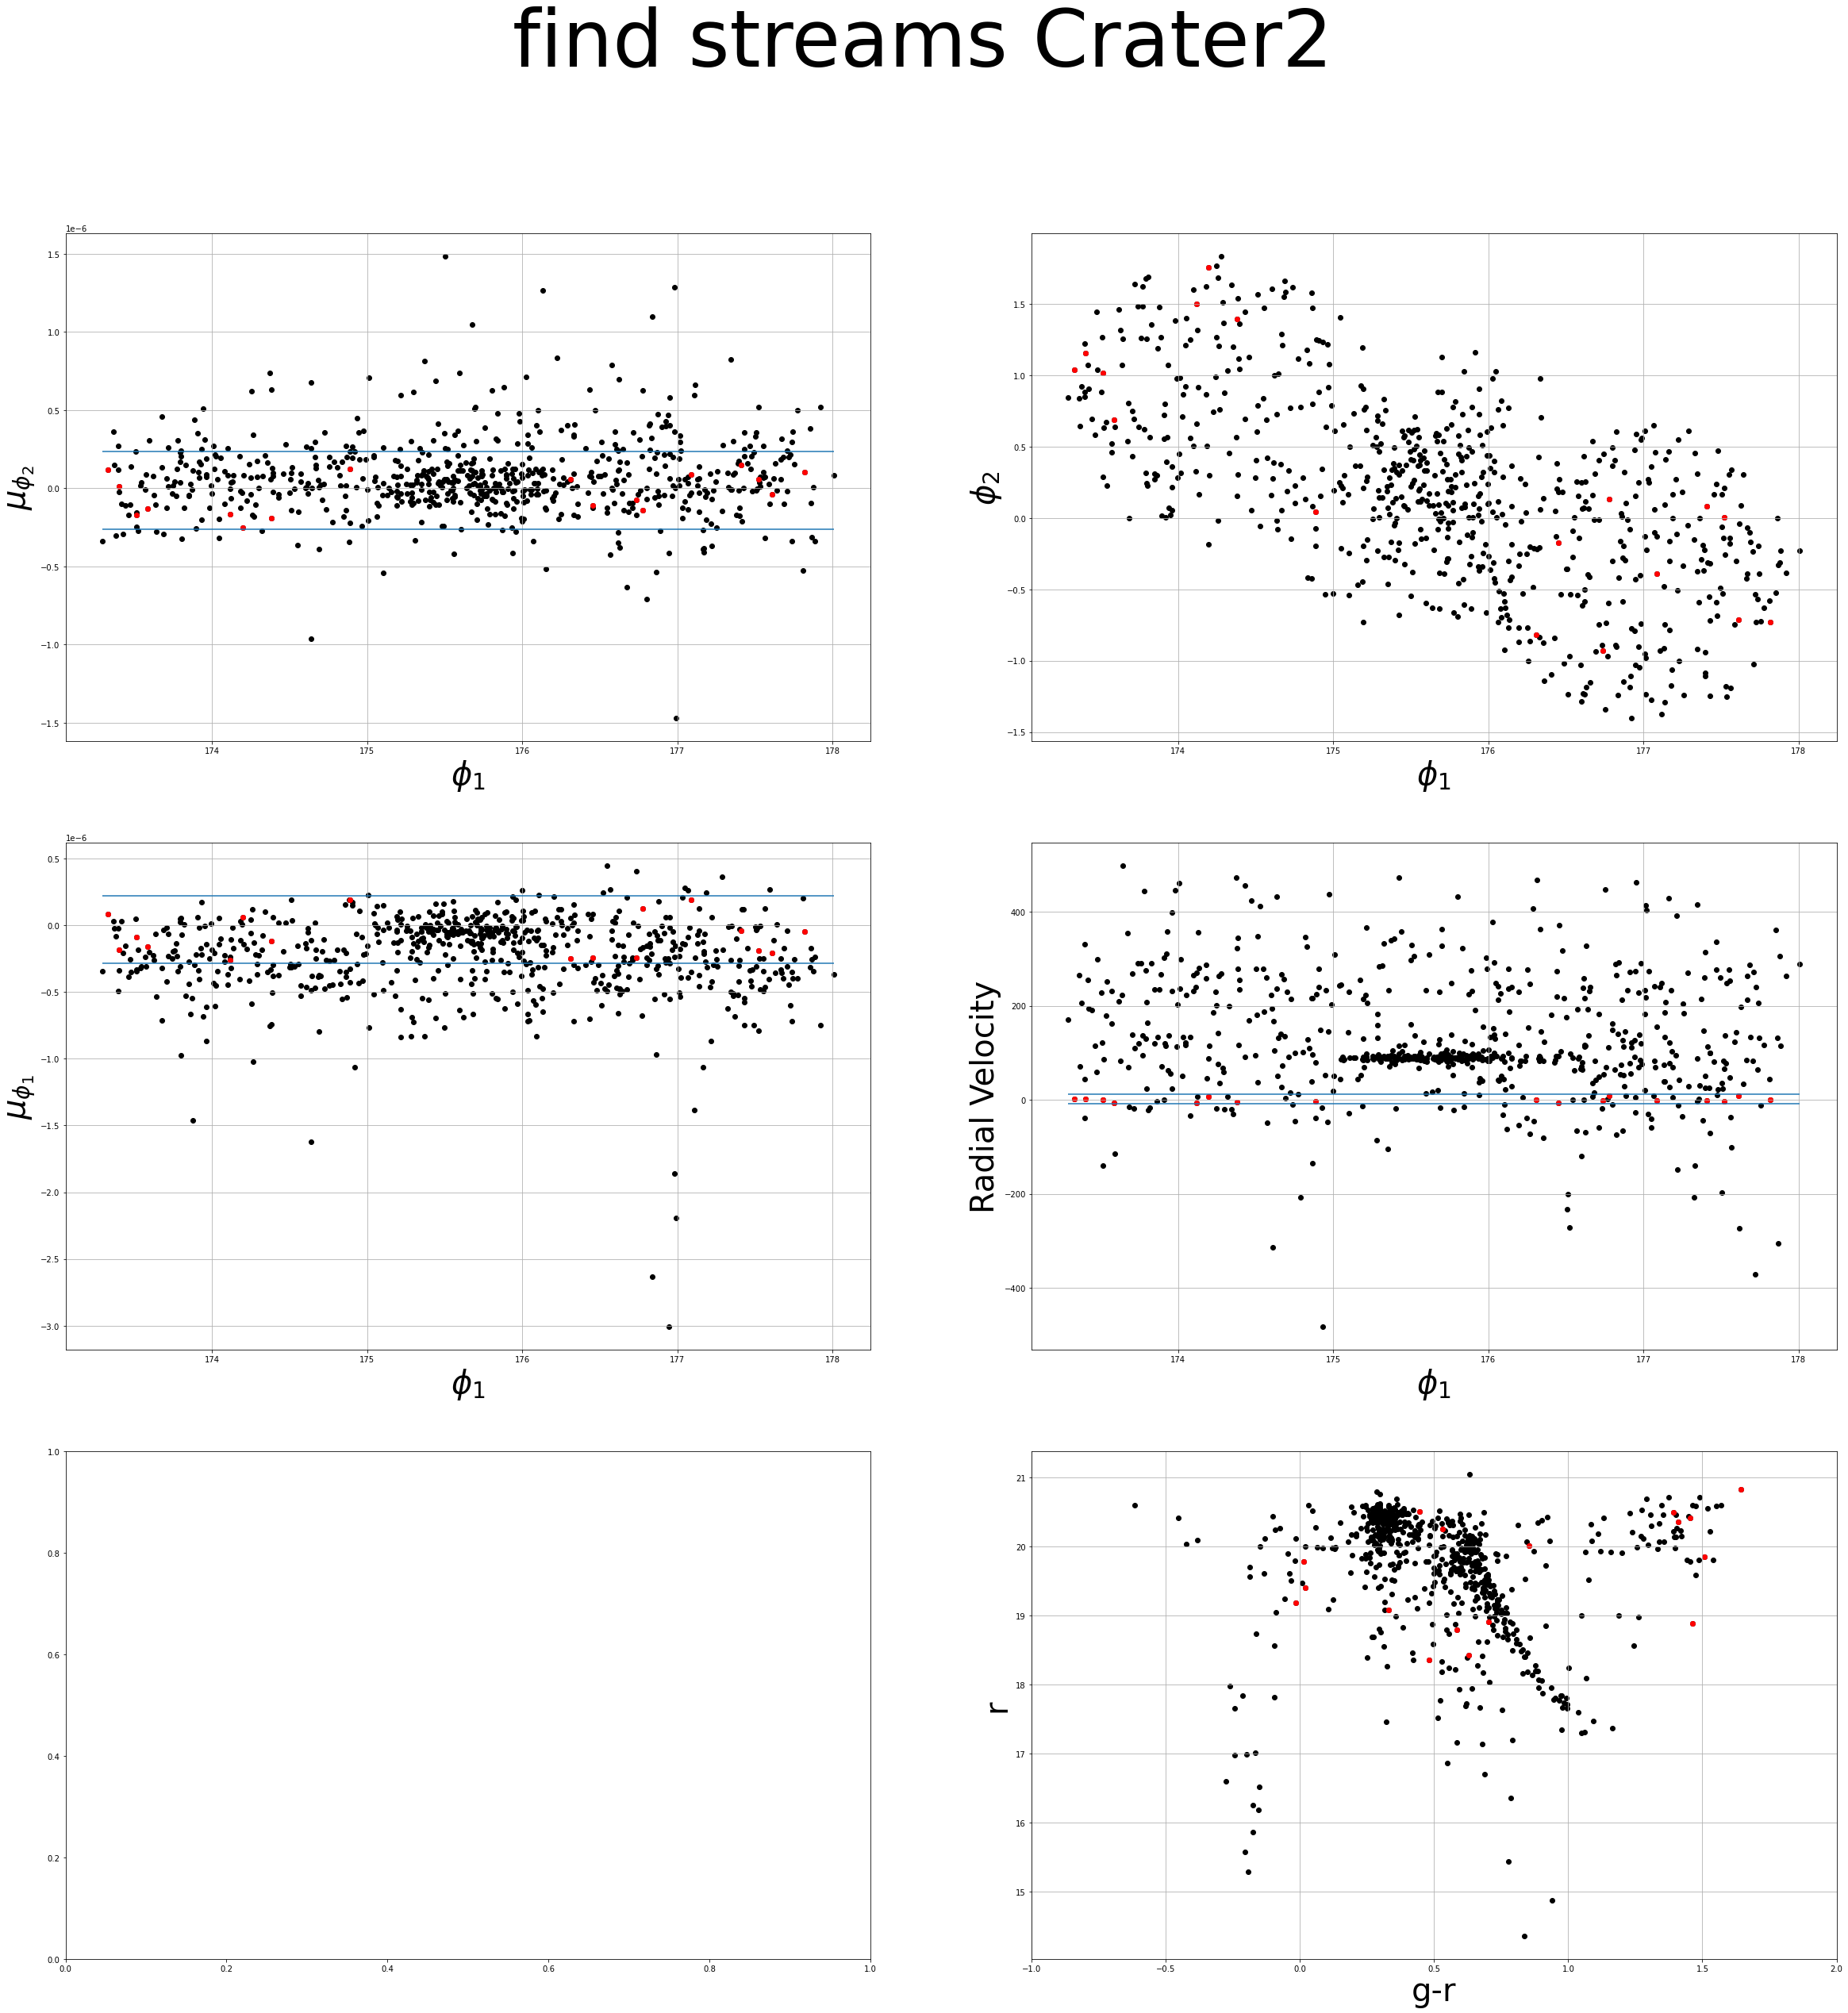

In [245]:
#plot 
plt.figure(figsize=(20,20))
fig, ((ax0, ax1), (ax2, ax3),(ax4,ax5)) = plt.subplots(nrows=3, ncols=2, figsize=(40, 40))
        
ax0.scatter(new_frame['original_phi_1'],new_frame['pmdec_rotated'],color='black')
ax0.scatter(masked['original_phi_1'],masked['pmdec_rotated'],color='r')
ax0.hlines(pmphi2-0.25*1e-6,new_frame['original_phi_1'].min(),new_frame['original_phi_1'].max())
ax0.hlines(pmphi2+0.25*1e-6,new_frame['original_phi_1'].min(),new_frame['original_phi_1'].max())
ax0.grid(True)
ax0.set_xlabel('$\phi_1$',fontsize=40)
ax0.set_ylabel('$\mu_{\phi_2}$',fontsize=40)


ax3.scatter(new_frame['original_phi_1'], new_frame['radial_velocity'],color='black')
ax3.scatter(masked['original_phi_1'], masked['radial_velocity'],color='r')
ax3.grid(True)
ax3.hlines(mean_radial_velocity-10,new_frame['original_phi_1'].min(),new_frame['original_phi_1'].max())
ax3.hlines(mean_radial_velocity+10,new_frame['original_phi_1'].min(),new_frame['original_phi_1'].max())
ax3.set_xlabel('$\phi_1$',fontsize=40)
ax3.set_ylabel('Radial Velocity',fontsize=40)

ax1.scatter(new_frame['original_phi_1'], new_frame['original_phi_2'],color='black')
ax1.scatter(masked['original_phi_1'],masked['original_phi_2'],color='r')
ax1.grid(True)
ax1.set_xlabel('$\phi_1$',fontsize=40)
ax1.set_ylabel('$\phi_2$',fontsize=40)

ax2.scatter(new_frame['original_phi_1'],new_frame['pmra_rotated_star'],color='black')
ax2.scatter(masked['original_phi_1'],masked['pmra_rotated_star'],color='r')
ax2.hlines(pmphi1-0.25*1e-6,new_frame['original_phi_1'].min(),new_frame['original_phi_1'].max())
ax2.hlines(pmphi1+0.25*1e-6,new_frame['original_phi_1'].min(),new_frame['original_phi_1'].max())
ax2.grid(True)
ax2.set_xlabel('$\phi_1$',fontsize=40)
ax2.set_ylabel('$\mu_{\phi_1}$',fontsize=40)


ax5.scatter(new_frame['g_band']-new_frame['r_band'],new_frame['r_band'],color='black') 
ax5.scatter(masked['g_band']-masked['r_band'],masked['r_band'],color='red')
ax5.grid(True)
ax5.set_xlabel('g-r',fontsize=40)
ax5.set_ylabel('r',fontsize=40)
#ax5.set_ylim(16,12)
ax5.set_xlim(-1,2)

        
fig.suptitle('find streams '+ name, fontsize=100)
fig.savefig('selection_clusters/find streams'+ stream +'.png')
plt.show()
